# CNN for Handwritten Prescription Classification

In [1]:
import kagglehub
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
root = kagglehub.dataset_download("mamun1113/doctors-handwritten-prescription-bd-dataset")
ds_dir = os.path.join(root, "Doctor’s Handwritten Prescription BD dataset")

train_csv = os.path.join(ds_dir, "Training",    "training_labels.csv")
train_img = os.path.join(ds_dir, "Training",    "training_words")
val_csv   = os.path.join(ds_dir, "Validation",  "validation_labels.csv")
val_img   = os.path.join(ds_dir, "Validation",  "validation_words")
test_csv = os.path.join(ds_dir, "Testing", "testing_labels.csv")
test_img = os.path.join(ds_dir, "Testing", "testing_words")

train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

train_df["filepath"] = train_df["IMAGE"].apply(lambda fn: os.path.join(train_img, fn))
val_df  ["filepath"] = val_df["IMAGE"].apply(lambda fn: os.path.join(val_img, fn))
test_df["filepath"] = test_df["IMAGE"].apply(lambda fn: os.path.join(test_img, fn))

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
  dataframe    = train_df,
  x_col        = "filepath",
  y_col        = "MEDICINE_NAME",
  target_size  = (128,128),
  batch_size   = 64,
  class_mode   = "categorical",
  shuffle      = True,
  seed         = 42
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe    = val_df,
    x_col        = "filepath",
    y_col        = "MEDICINE_NAME",
    target_size  = (128,128),
    batch_size   = 64,
    class_mode   = "categorical",
    shuffle      = False
)


test_gen = val_test_datagen.flow_from_dataframe(
    dataframe   = test_df,
    x_col       = "filepath",
    y_col       = "MEDICINE_NAME",
    target_size = (128,128),
    batch_size  = 32,
    class_mode  = "categorical",
    shuffle     = False
)


Found 3120 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.
Found 780 validated image filenames belonging to 78 classes.


In [ ]:
# def build_vgg_model():
#     base_model = VGG16(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(128, 128, 3)
#     )

#     base_model.trainable = False

#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(78, activation='softmax')  # 78 classses
#     ])

#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

# vgg_model = build_vgg_model()
# vgg_model.summary()
# epochs = 100

# history = vgg_model.fit(
#     train_gen,
#     epochs=epochs,
#     validation_data=val_gen,
# )

In [ ]:
# def build_vgg2_model():
#     base_model = VGG16(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(128, 128, 3)
#     )

#     base_model.trainable = True
#     for layer in base_model.layers[:-4]:      # ufreeze final 4 layers
#         layer.trainable = False

#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(256, activation='relu'),        # 2x da capacity
#         Dropout(0.5),
#         Dense(78, activation='softmax')
#     ])

#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

# # If performance is poor:
# # unfreeze some VGG16 layers --> fine-tuning
# # adj classifier arcg ---- more dense layers?

# vgg2_model = build_vgg2_model()
# vgg2_model.summary()
# epochs = 100

# history = vgg2_model.fit(
#     train_gen,
#     epochs=epochs,
#     validation_data=val_gen,
# )

In [3]:
def build_vgg3_model():
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3)
    )

    base_model.trainable = False

    model = Sequential([
        base_model,
        # Flatten(),
        # Dense(128, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        Dropout(0.5),
        Dense(78, activation='softmax')  # 78 classses
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_vgg3_model()

history = model.fit(
    train_gen,
    epochs=40,
    validation_data=val_gen,
)

# fine-tune deeper layers
model.layers[0].trainable = True
for layer in model.layers[0].layers[:-8]:
    layer.trainable = False

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.0390 - loss: 7.9427 - val_accuracy: 0.1423 - val_loss: 6.4402
Epoch 2/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 469ms/step - accuracy: 0.1355 - loss: 5.5693 - val_accuracy: 0.2192 - val_loss: 4.7922
Epoch 3/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.2375 - loss: 4.4543 - val_accuracy: 0.3321 - val_loss: 3.9105
Epoch 4/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.2827 - loss: 4.0048 - val_accuracy: 0.3756 - val_loss: 3.5573
Epoch 5/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.3431 - loss: 3.5394 - val_accuracy: 0.4256 - val_loss: 3.2271
Epoch 6/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.3964 - loss: 3.1862 - val_accuracy: 0.4833 - val_loss: 2.9636
Epoch 7/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 396ms/step - accuracy: 0.4334 - loss: 2.9105 - val_accuracy: 0.4846 - val_loss: 2.8633
Epoch 8/40
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.4521 - loss: 2.8092 - val_accurac

In [4]:
loss, acc = model.evaluate(val_gen)
print(f"Validation accuracy: {acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.8988 - loss: 1.4344
Validation accuracy: 0.8744


In [5]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.8344 - loss: 0.9899
Test Loss: 1.2677
Test Accuracy: 0.7910


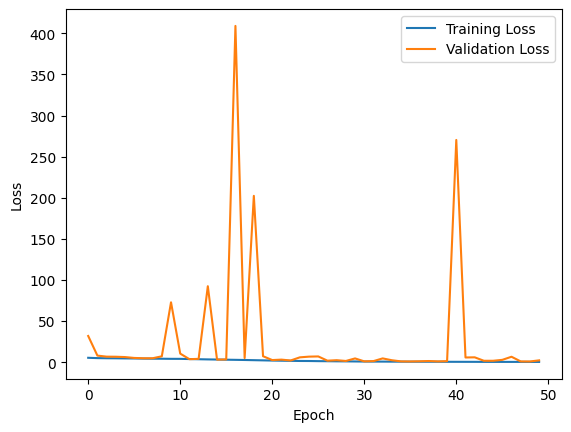

In [6]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

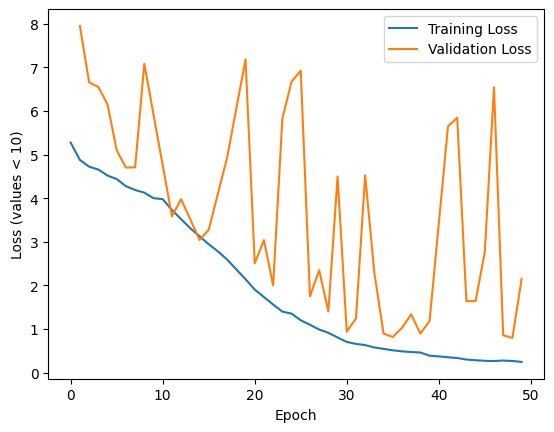

In [9]:
import numpy as np

# Filter out loss values >= 10
train_loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

# Create masks for values under 10
train_mask = train_loss < 10
val_mask = val_loss < 10

plt.plot(np.arange(len(train_loss))[train_mask],
         train_loss[train_mask],
         label='Training Loss')
plt.plot(np.arange(len(val_loss))[val_mask],
         val_loss[val_mask],
         label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (values < 10)')
plt.legend()
plt.show()

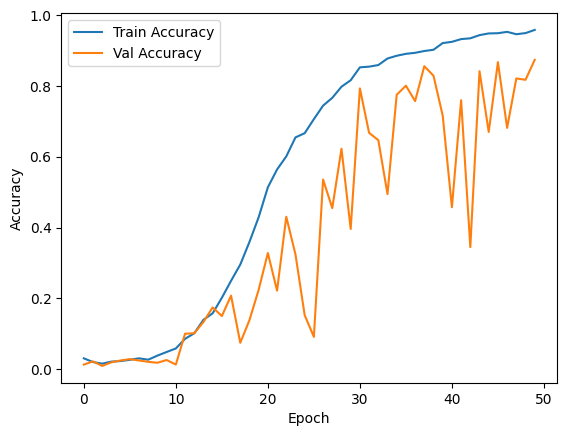

In [7]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
import numpy as np
from sklearn.metrics import classification_report

# Predict class probabilities
pred_probs = model.predict(test_gen)

# Get predicted class indices
y_pred = np.argmax(pred_probs, axis=1)

# Get true class indices
y_true = test_gen.classes

class_labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
              precision    recall  f1-score   support

         Ace       0.78      0.70      0.74        10
       Aceta       1.00      1.00      1.00        10
     Alatrol       0.80      0.80      0.80        10
      Amodis       0.91      1.00      0.95        10
     Atrizin       0.56      1.00      0.71        10
      Axodin       0.31      1.00      0.48        10
          Az       0.80      0.80      0.80        10
  Azithrocin       0.71      1.00      0.83        10
       Azyth       0.91      1.00      0.95        10
      Bacaid       0.91      1.00      0.95        10
    Backtone       1.00      1.00      1.00        10
    Baclofen       1.00      0.90      0.95        10
      Baclon       0.71      1.00      0.83        10
      Bacmax       1.00      1.00      1.00        10
       Beklo       1.00      0.20      0.33        10
     Bicozin       0.89      0.80      0.84        10
    Canazole       1.00      0.70      0.